In [53]:
from scipy.io import loadmat
import numpy as np

In [54]:
def calc_fairness_metric(constraint, confu_mat, num_groups=2, num_classes=2):
    if constraint == 'eopp':
        '''
        Compute EO disparity
        '''
        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()

        pivot = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        return max(abs(group0_tpr - pivot), abs(group1_tpr - pivot)) # from fairbatch paper
        #return abs(group0_tp / (group0_fn + group0_tp) - group1_tp / (group1_fn + group1_tp))

    elif constraint == 'eo':
        '''
        Compute ED disparity 
        '''

        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
        
        pivot_1 = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        EO_Y_1 = max(abs(group0_tpr - pivot_1), abs(group1_tpr - pivot_1))

        pivot_0 = (group0_fp + group1_fp) / (group0_tn + group0_fp + group1_tn + group1_fp)
        group0_fpr = (group0_fp) / (group0_tn + group0_fp)
        group1_fpr = (group1_fp) / (group1_tn + group1_fp)

        EO_Y_0 = max(abs(group0_fpr - pivot_0), abs(group1_fpr - pivot_0))

        return max(EO_Y_0, EO_Y_1)

    elif constraint == 'dp':
        pass

def calc_acc(constraint, confu_mat, num_classes=2, num_groups=2):
    group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
    group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
    
    return (group0_tn + group0_tp + group1_tn + group1_tp) / (confu_mat['0'].ravel().sum() + confu_mat['1'].ravel().sum())


In [55]:

method = "adv_debiasing"
dataset = "compas"
sen_attr_dict = {
    "adult": "sex",
    "compas": "sex",
    "retiring_adult": "race",
    "retiring_adult_coverage": "race"
}

sen_attr = sen_attr_dict[dataset]
constraint = "eopp"


In [56]:

filename_epi = "mlp_{}_seed{}_epochs50_bs128_lr{:.4f}_decay{:.4f}"
seed_arr = [0, 1, 2]
date = "20220214"

if method == "reweighting":
    pass
elif method == "adv_debiasing":
    filename = filename_epi + "_adv_lamb{}_eta{}_constraint{}_test_confu"
    lr = 0.0005
    decay = 0.0005
#     lamb_arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lamb_arr = [0.001, 0.003, 0.1, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 20.0, 30.0, 50.0, 100.0]
#     lamb_arr = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 20.0, 30.0, 50.0, 100.0]
#     eta_arr = [0.001, 0.003, 0.005, 0.007, 0.01]
    eta_arr = [0.001, 0.003, 0.005, 0.01]
    


In [57]:

results_fair = np.zeros((len(seed_arr), len(eta_arr), len(lamb_arr)))
results_acc = np.zeros((len(seed_arr), len(eta_arr), len(lamb_arr)))

for seed in seed_arr:
    for i, eta in enumerate(eta_arr):
        for j, lamb in enumerate(lamb_arr):
            confu_mat = loadmat("./results/{}/{}/{}/{}".format(date, dataset, method, filename.format(sen_attr, seed, lr, decay, lamb, eta, constraint)), appendmat=False)
#             print(calc_fairness_metric(constraint, confu_mat))
            results_fair[seed, i, j] += calc_fairness_metric(constraint, confu_mat)
            results_acc[seed, i, j] += calc_acc(constraint, confu_mat)

results_fair = np.mean(results_fair, axis=0)
results_acc = np.mean(results_acc, axis=0)


print(results_fair, results_acc)


[[0.24778767 0.24899759 0.18807946 0.21617496 0.18807946 0.1034131
  0.07399513 0.05956752 0.09496476 0.0375146  0.03028321 0.03403959
  0.01336541]
 [0.24451666 0.2439117  0.18565962 0.20987915 0.18565962 0.12097807
  0.09106769 0.06335204 0.026358   0.12727388 0.11810099 0.09005473
  0.03598813]
 [0.24451666 0.2439117  0.18299357 0.21315016 0.18299357 0.13381589
  0.08961156 0.05764009 0.09630833 0.08311878 0.04857975 0.04269897
  0.08366747]
 [0.24512163 0.24718271 0.1874745  0.21194024 0.1874745  0.1340621
  0.0973635  0.08548939 0.1370447  0.05091518 0.07381927 0.04994443
  0.04541426]] [[0.66990816 0.67071853 0.66828741 0.67071853 0.66828741 0.66909778
  0.66693679 0.66342518 0.63317126 0.60345759 0.54430038 0.50864398
  0.52701243]
 [0.67044841 0.67044841 0.66909778 0.66990816 0.66909778 0.66990816
  0.67044841 0.6537007  0.61858455 0.58562939 0.54862237 0.55807672
  0.51296596]
 [0.67071853 0.67017828 0.66909778 0.66936791 0.66909778 0.67098865
  0.66774716 0.65667207 0.6142625

In [58]:

argmin = np.unravel_index(results_fair.argmin(), results_fair.shape)
print(argmin)
print(results_fair[argmin], results_acc[argmin])


(0, 12)
0.013365410318096772 0.5270124257158293


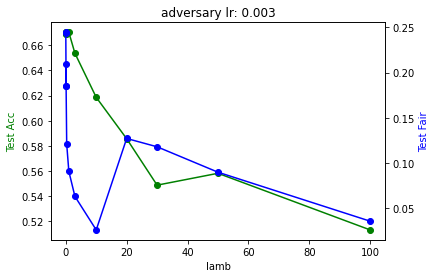

In [65]:

import matplotlib.pyplot as plt

lr_idx = 1

x = lamb_arr
y1 = results_acc[lr_idx, :]
y2 = results_fair[lr_idx, :]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'go-')
ax2.plot(x, y2, 'bo-')

ax1.set_xlabel('lamb')
ax1.set_ylabel('Test Acc', color='g')
ax2.set_ylabel('Test Fair', color='b')

plt.title(f"adversary lr: {eta_arr[lr_idx]}")

plt.show()


